In [1]:
import torch
import torch.nn as nn
from utils.useful_func import *

# 1、加性注意力

In [46]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention,self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q = nn.Linear(query_size,num_hiddens,bias=False)
        self.W_v = nn.Linear(num_hiddens,1,bias=False)
        self.dropout = nn.Dropout(dropout)
    # queries 维度应该是 batch_size * 要查询的数量 * q_size向量长度
    # keys 维度是 batch_size * keys的数量（key-value)键值对 * key向量长度
    # values与key相等 value_size可以不一样
    def forward(self, queries, keys, values, valid_lens): ## valid_len从输入来的 屏蔽掉填充部分
        queries,keys=self.W_q(queries),self.W_k(keys)
        queries=queries.unsqueeze(2)
        keys=keys.unsqueeze(1)
        features = queries + keys
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        attention_temp=self.dropout(self.attention_weights)
        return torch.bmm(attention_temp, values)

In [11]:
queries=torch.normal(0,1,size=[2,1,20])
keys=torch.ones([2,10,2])
values=torch.arange(40,dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = torch.tensor([2, 6])

In [51]:
attention=AdditiveAttention(2,20,128,dropout=0.2)

In [52]:
attention(queries,keys,values,valid_lens = torch.tensor([2, 6]))

tensor([[[ 2.5000,  3.1250,  3.7500,  4.3750]],

        [[12.5000, 13.7500, 15.0000, 16.2500]]], grad_fn=<BmmBackward0>)

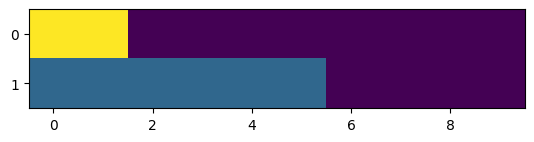

In [60]:
plt.imshow(attention.attention_weights.detach().numpy().squeeze())

# 缩放点积注意力

In [9]:
class DotAttention(nn.Module):
    def __init__(self,dropout,**kwargs):
        super(DotAttention,self).__init__()
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens):
        d=keys.shape[-1]
        scores =torch.matmul(queries,keys.transpose(1,2))/torch.sqrt(torch.tensor(d))
        self.attention_weights =masked_softmax(scores,valid_lens)
        return torch.bmm(self.attention_weights,values)


In [12]:
queries = torch.normal(0, 1, (2, 1, 2))
keys=torch.ones([2,10,2])
values=torch.arange(40,dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
attention = DotAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])